In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import random
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from Credit_Maml import *


In [2]:
conn = sqlite3.connect('data_std.db')
scripts = '''select * from credit_default_pred'''
data_std = pd.read_sql(scripts, conn)
data_std

,A105,A106,A116,A401,A509,A511,A517,A519,A609,A611,...,R906,SUD1,T310,XCNL,XCPA,XCTL,XGRP,XMTG,XPYR,是否違約
0,0.155906,0.010461,-0.401397,-0.046266,0.334499,-0.142139,-0.087050,0.294049,-0.404180,-0.013853,...,1.216554,0.150698,2.683424,-0.377492,-0.135021,-1.164123,-0.662574,-0.795279,-0.114314,0.0
1,0.082568,0.010461,-0.430237,0.006949,0.437604,-0.142139,-0.090957,0.392044,-0.412637,-0.014003,...,1.443770,0.205122,2.886790,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
2,0.096319,0.010461,-0.427540,-0.012908,0.707057,-0.142139,-0.090957,0.648142,-0.415240,-0.014008,...,1.300948,0.259546,3.034055,2.649062,-0.135021,-1.145749,1.423786,-0.795279,-0.114314,0.0
3,0.371911,0.010463,-0.363939,-0.065520,1.092298,-0.142139,-0.065388,1.014289,-0.418615,-0.013812,...,1.239275,0.313970,3.041067,2.649062,-0.135021,-0.358445,1.771513,-0.795279,-0.114314,0.0
4,0.568435,0.010464,-0.386761,-0.014787,1.312830,-0.142139,-0.026679,1.223891,-0.421827,-0.013747,...,0.950386,0.368394,3.181319,2.649062,-0.135021,-0.358445,1.771513,-0.795279,-0.114314,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9143,-0.156928,0.010463,-0.490901,0.478554,0.136572,-0.142139,-0.015670,0.105932,-0.307407,-0.014542,...,2.154632,2.037036,-0.689642,-0.377492,-0.135021,-0.840627,-0.662574,0.733134,-0.114314,0.0
9144,-0.344858,0.010462,-0.457150,0.083593,-0.017524,-0.142139,-0.028100,-0.040526,-0.276993,-0.014539,...,2.719427,2.091460,-0.331999,-0.377492,-0.135021,-0.770471,-0.662574,1.602591,-0.114314,0.0
9145,-0.003949,0.010462,-0.603419,0.127576,0.538983,-0.142139,0.018066,0.488398,-0.265120,-0.014546,...,1.346392,2.145884,0.095770,-0.377492,-0.135021,-0.770471,-0.662574,1.661794,-0.114314,0.0
9146,-0.205056,0.010462,-0.425229,0.115165,0.206028,-0.142139,0.074176,0.171945,-0.266991,-0.014547,...,1.924170,2.200308,0.502502,-0.377492,-0.135021,-0.978711,-0.662574,1.668944,-0.114314,1.0


In [3]:
len(np.where(data_std['是否違約']==1)[0])

121

## Train/Test Split
- Test/Train ratio = 0.7

In [4]:
from sklearn.model_selection import train_test_split
X = data_std.loc[:,data_std.columns.difference(['是否違約'])]
y = data_std['是否違約']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
len(np.where(y_train==1)[0])

82

## 重複抽樣 + Few shot learning
本研究採用bagging的方式來建立MLP模型<br>
bagging->組合不同樣本訓練出來的模型後，再將預測值取平均<br>
違約資料有樣本不平衡之問題(1僅占樣本的1%)，重複抽樣的方式還需穩定每組樣本0和1之比例(固定70%/30%)<br>


In [62]:
# 產生亂數組
n_task = 100
n_meta_update = 100
seed_sets = np.zeros((n_meta_update, n_task))
for i in range(n_meta_update):
    seeds = np.random.choice(10000000, n_task)
    seed_sets[i] = seeds
np.save('seed_sets.npy', seed_sets)

In [63]:
# 讀取預先製作的亂數組
seed_sets = np.load('seed_sets.npy')
val_seed_sets = np.load('val_seed_sets.npy')
seed_sets = seed_sets.astype(int)
val_seed_sets = val_seed_sets.astype(int)

In [48]:
credit_pred = Credit_Maml(X_train.values, y_train.values, n_meta_update=50, n_task=100, ways = [0,1], n_shots=10)
# x = series_to_image(X_train, 11)
x, y = credit_pred.generate_multiple_tasks(credit_pred.seed_series[0])
x.shape, y.shape

((100, 2, 10, 114), (100, 2, 10, 2))

In [8]:
credit_pred.CNN_model((11,11)).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 10, 9, 9, 32)   320       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 10, 7, 7, 64)   18496     
                                                                 
 dense (Dense)               (None, 2, 10, 7, 7, 2)    130       
                                                                 
Total params: 18,946
Trainable params: 18,946
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result= {'weights':{}, 'history':{}}
 
for n_task in [10, 50, 100]:
    result['weights'][str(n_task)] = {}
    result['history'][str(n_task)] = {}
    for n_shots in [1, 2, 5, 10, 30, 50]:
        result['weights'][str(n_task)][str(n_shots)] = {}
        result['history'][str(n_task)][str(n_shots)] = {}
        for i in range(30):
            credit_pred = Credit_Maml(X_train.values, y_train.values, n_meta_update = 60, n_task = n_task, ways=[0,1], n_shots=n_shots)
            new_weight, history = credit_pred.train_step(inner_lr=0.001, outer_lr=1e-4, early_stop=10)
            np.save(f'./maml_model/CNN_50_iter_{n_task}_tasks_2_ways_{n_shots}_shots_{i}', new_weight)
            np.save(f'./maml_model/history_50_iter_{n_task}_tasks_2_ways_{n_shots}_shots_{i}', history)
            result['weights'][str(n_task)][str(n_shots)][str(i)] = new_weight
            result['history'][str(n_task)][str(n_shots)][str(i)] = history


## Loss analysis

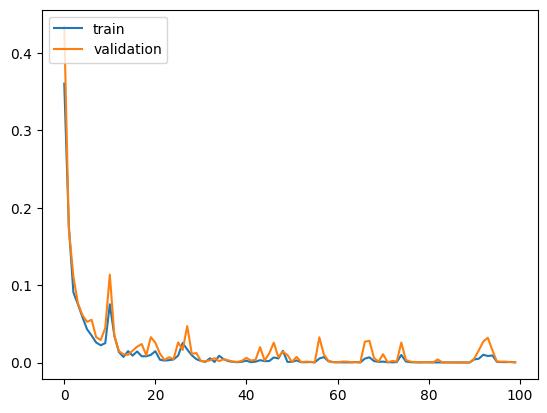

In [475]:
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'validation')
plt.legend(loc = 2)